# Recommendation System with MovieLens Dataset
Related datasets can be found here http://grouplens.org/datasets/movielens/


In [1]:
import os
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix

In [9]:
link = "https://files.grouplens.org/datasets/movielens/ml-25m.zip"

# download to ./data if not already downloaded
target = "data/ml-25m"
if not os.path.exists("data/ml-25m"):
    os.system("wget " + link + " -P data")
    os.system(f"unzip {target}.zip -d data")
    os.system(f"rm {target}.zip")

--2024-06-19 10:52:16--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
正在解析主机 files.grouplens.org (files.grouplens.org)... 128.101.65.152
正在连接 files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：4924029 (4.7M) [application/zip]
正在保存至: “data/ml-100k.zip”

     0K .......... .......... .......... .......... ..........  1% 81.9K 58s
    50K .......... .......... .......... .......... ..........  2%  183K 42s
   100K .......... .......... .......... .......... ..........  3% 7.47M 28s
   150K .......... .......... .......... .......... ..........  4%  101K 32s
   200K .......... .......... .......... .......... ..........  5%  117M 25s
   250K .......... .......... .......... .......... ..........  6%  233M 21s
   300K .......... .......... .......... .......... ..........  7%  215K 21s
   350K .......... .......... .......... .......... ..........  8% 2.29M 18s
   400K .......... .......... .......... .......... ..........  9%

Archive:  data/ml-100k.zip
   creating: data/ml-100k/
  inflating: data/ml-100k/allbut.pl  
  inflating: data/ml-100k/mku.sh     
  inflating: data/ml-100k/README     
  inflating: data/ml-100k/u.data     
  inflating: data/ml-100k/u.genre    
  inflating: data/ml-100k/u.info     
  inflating: data/ml-100k/u.item     
  inflating: data/ml-100k/u.occupation  
  inflating: data/ml-100k/u.user     
  inflating: data/ml-100k/u1.base    
  inflating: data/ml-100k/u1.test    
  inflating: data/ml-100k/u2.base    
  inflating: data/ml-100k/u2.test    
  inflating: data/ml-100k/u3.base    
  inflating: data/ml-100k/u3.test    
  inflating: data/ml-100k/u4.base    
  inflating: data/ml-100k/u4.test    
  inflating: data/ml-100k/u5.base    
  inflating: data/ml-100k/u5.test    
  inflating: data/ml-100k/ua.base    
  inflating: data/ml-100k/ua.test    
  inflating: data/ml-100k/ub.base    
  inflating: data/ml-100k/ub.test    


In [14]:
movies_csv_path = "movies.csv"
ratings_csv_path = "ratings.csv"
tags_csv_path = "tags.csv"
genome, genome_tags = "genome-scores.csv", "genome-tags.csv"

movies_df = pd.read_csv("./data/ml-25m/" + movies_csv_path)
print("Size of movies.csv: ", movies_df.shape)
movies_df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/ml-100k/movies.csv'

Text(0.5, 1.0, 'Year counts')

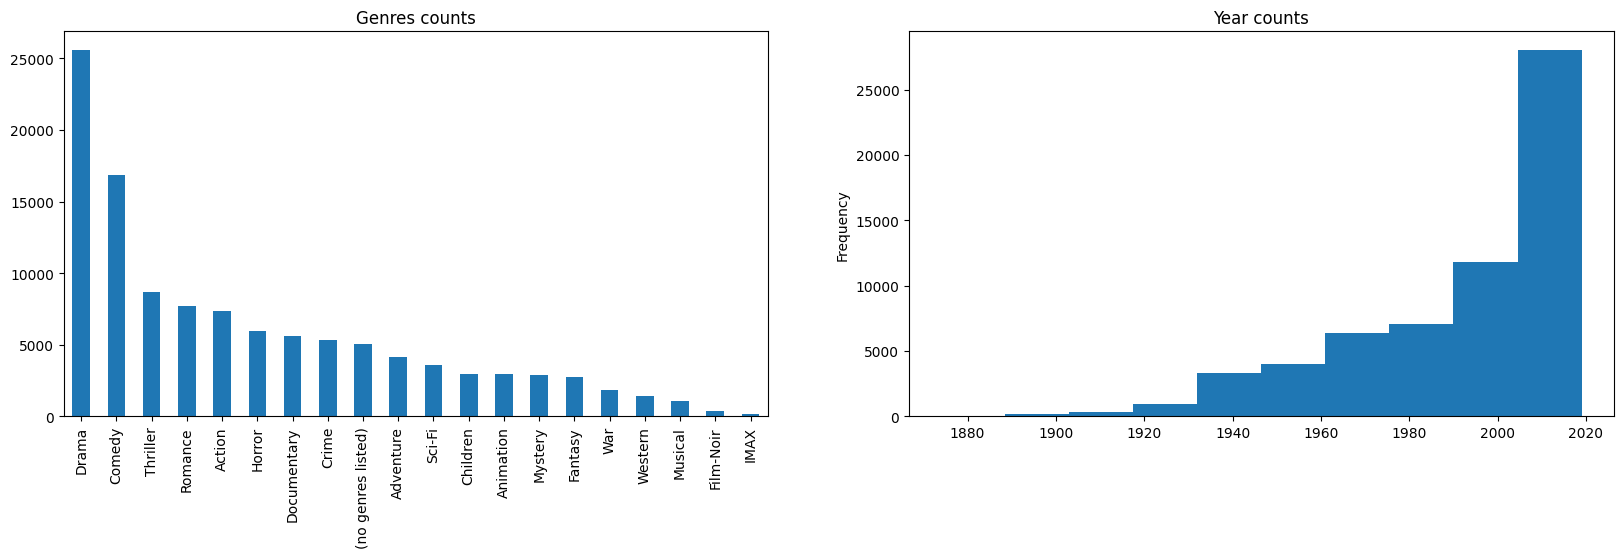

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

# Graph genres counts
genres = movies_df["genres"].str.split("|", expand=True)
genres = genres.stack().value_counts()
genres.plot(kind="bar", ax=axes[0])

# Plot year counts
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)")
movies_df["year"] = movies_df["year"].astype(float)
movies_df["year"].plot(kind="hist", ax=axes[1])

# Add some titles
axes[0].set_title("Genres counts")
axes[1].set_title("Year counts")



In [12]:
ratings_df = pd.read_csv("./data/ml-25m/" + ratings_csv_path)
print("Size of ratings.csv: ", ratings_df.shape)
# ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s') # convert timestamp to datetime
ratings_df.head(5)

Size of ratings.csv:  (25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [7]:
unique_users = ratings_df["userId"].nunique()
unique_movies = ratings_df["movieId"].nunique()

print(f"Unique users: {unique_users}")
print(f"Unique movies: {unique_movies}")

Unique users: 162541
Unique movies: 59047


In [6]:
# Train/test split with 80/20 ratio, sample only 10% of the data
seed = 42
sample_size = 0.1
print(f"Total ratings before sampling: {len(ratings_df)}")
ratings_df = ratings_df.sample(frac=sample_size, random_state=seed)

print(f"Total ratings after sampling: {len(ratings_df)}")

train_size = int(0.8 * len(ratings_df))
train_df = ratings_df[:train_size]
test_df = ratings_df[train_size:]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

del ratings_df # to save memory

Total ratings before sampling: 25000095
Total ratings after sampling: 2500010
Train size: 2000008
Test size: 500002


## Memory Based Collaborative Filtering

### User-Based CF

- train_df memory size: 35304.67 MB
- train_sparse memory size: 25.51 MB

In [10]:
# Create the preference matrix,
# train_df = train_df.pivot(index="userId", columns="movieId", values="rating")
# memory_usage = train_df.memory_usage().sum() # Calculate total memory usage
# print(f"Total memory usage: {memory_usage / 1024**2:.2f} MB")


# Create the preference matrix but with sparse
train_sparse = csr_matrix((train_df["rating"], (train_df["userId"], train_df["movieId"])))
memory_usage = train_sparse.data.nbytes + train_sparse.indptr.nbytes + train_sparse.indices.nbytes
print(f"Total memory usage: {memory_usage / 1024**2:.2f} MB")

# Calcuate sparsity
sparsity = 1 - (train_sparse.count_nonzero() / (train_sparse.shape[0] * train_sparse.shape[1]))
print(f"Sparsity: {sparsity:.8f}")

# del train_df # to save memory


Total memory usage: 23.51 MB
Sparsity: 0.99994117


## Item-Based CF